In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import *

In [42]:
def func(x):
    return x**3 - 3 * sin(x)

def deriv1(x):
    return 3*x**2 - 3*cos(x)

In [43]:
f = np.vectorize(func)
minimum = scipy.optimize.minimize(f, 1)
minimum

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.642130412914144
        x: [ 8.241e-01]
      nit: 3
      jac: [ 1.073e-06]
 hess_inv: [[ 1.398e-01]]
     nfev: 10
     njev: 5

In [49]:
minimal_brent = scipy.optimize.brent(func, brack = (0,1), full_output = True)
print(minimal_brent, minimum['x'][0])

(0.8241323111380852, -1.6421304129142098, 10, 13) 0.8241324484434951


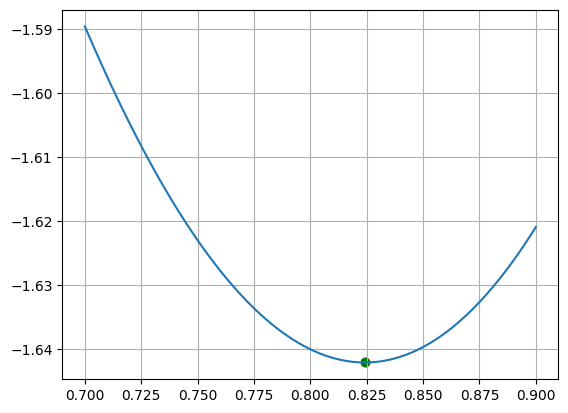

In [45]:
x = np.arange(0.7, 0.9, 0.001)
plt.plot(x, f(x))
plt.scatter(minimum['x'], minimum['fun'], color = 'red')
plt.scatter(minimal_brent[0], minimal_brent[1], color = 'green')
plt.grid(True)

3 задание

In [ ]:
def 